<a href="https://colab.research.google.com/github/meltyyyyy/signate-sc2022/blob/main/Notebooks/lgb/001_lgb_preprocess.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

こちらのnotebookを参考にテキストを文字列に変換して特徴抽出を行った。
https://www.guruguru.science/competitions/16/discussions/fb792c87-6bad-445d-aa34-b4118fc378c1/

In [1]:
!pip install nlp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import collections
import os
import random

import matplotlib.pyplot as plt
import nlp
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.model_selection import StratifiedKFold
from tqdm.notebook import tqdm
from transformers import AdamW, AutoModel, AutoTokenizer

In [4]:
from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/MyDrive/00_datascience/16_studentcup'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/00_datascience/16_studentcup


In [5]:
# seeds
SEED = 42
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

seed_everything(SEED)

if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    current_device = torch.cuda.current_device()
    print("Device:", torch.cuda.get_device_name(current_device))

Device: Tesla T4


In [6]:
# config
data_dir = '/content/drive/MyDrive/00_datascience/16_studentcup/input'
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
TRAIN_FILE = '/content/drive/MyDrive/00_datascience/16_studentcup/input/train.csv'
TEST_FILE = '/content/drive/MyDrive/00_datascience/16_studentcup/input/test.csv'
SUB_FILE = '/content/drive/MyDrive/00_datascience/16_studentcup/input/submit_sample.csv'
MODELS_DIR = "./models/"
MODEL_NAME = 'bert-base-uncased'
TRAIN_BATCH_SIZE = 32
VALID_BATCH_SIZE = 128
NUM_CLASSES = 4
EPOCHS = 5
NUM_SPLITS = 5

In [7]:
train = pd.read_csv(TRAIN_FILE)
test = pd.read_csv(TEST_FILE)
sub = pd.read_csv(SUB_FILE)

In [8]:
train.head()

,id,description,jobflag
0,0,<li>Develop cutting-edge web applications that...,3
1,1,"<li> Designs and develops high quality, scalab...",3
2,2,<li>Functions as a point person for Network St...,4
3,3,"<li> Work on the technical design, development...",3
4,4,<li>Quantify the resources required for a task...,4


In [9]:
import re
from nltk.stem.porter import PorterStemmer
stemmer = PorterStemmer()

def cleaning(texts):
    clean_texts = []
    for text in texts:
        # htmlタグを削除
        text = remove_tag(text)
        #アルファベット以外をスペースに置き換え
        clean_punc = re.sub(r'[^a-zA-Z]', ' ', text)
        #単語長が3文字以下のものは削除する
        clean_short_tokenized = [word for word in clean_punc.split() if len(word) > 3]
        #ステミング
        clean_normalize = [stemmer.stem(word) for word in clean_short_tokenized]
        #単語同士をスペースでつなぎ, 文章に戻す
        clean_text = ' '.join(clean_normalize)
        clean_texts.append(clean_text)
    return clean_texts

def remove_tag(x):
    p = re.compile(r"<[^>]*?>")
    return p.sub('',x)

train_cleaned = train.copy()
test_cleaned = test.copy()

train_cleaned['description'] = cleaning(train_cleaned['description'])
test_cleaned['description'] = cleaning(test_cleaned['description'])

In [10]:
import pandas as pd
import numpy as np
import torch
import transformers

from transformers import BertTokenizer
from tqdm import tqdm
tqdm.pandas()

In [11]:
class BertSequenceVectorizer:
    def __init__(self):
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.model_name = 'bert-base-uncased'
        self.tokenizer = BertTokenizer.from_pretrained(self.model_name)
        self.bert_model = transformers.BertModel.from_pretrained(self.model_name)
        self.bert_model = self.bert_model.to(self.device)
        self.max_len = 128


    def vectorize(self, sentence : str) -> np.array:
        inp = self.tokenizer.encode(sentence)
        len_inp = len(inp)

        if len_inp >= self.max_len:
            inputs = inp[:self.max_len]
            masks = [1] * self.max_len
        else:
            inputs = inp + [0] * (self.max_len - len_inp)
            masks = [1] * len_inp + [0] * (self.max_len - len_inp)

        inputs_tensor = torch.tensor([inputs], dtype=torch.long).to(self.device)
        masks_tensor = torch.tensor([masks], dtype=torch.long).to(self.device)

        bert_out = self.bert_model(inputs_tensor, masks_tensor)
        seq_out, pooled_out = bert_out['last_hidden_state'], bert_out['pooler_output']

        if torch.cuda.is_available():    
            return seq_out[0][0].cpu().detach().numpy() # 0番目は [CLS] token, 768 dim の文章特徴量
        else:
            return seq_out[0][0].detach().numpy()

In [12]:
BSV = BertSequenceVectorizer()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [13]:
train_cleaned['description_feature'] = train_cleaned['description'].progress_apply(lambda x: BSV.vectorize(x))
test_cleaned['description_feature'] = test_cleaned['description'].progress_apply(lambda x: BSV.vectorize(x))

100%|██████████| 1517/1517 [00:24<00:00, 61.01it/s]


In [14]:
train_cleaned.head()

,id,description,jobflag,description_feature
0,0,develop cut edg applic that perform superbl ac...,3,"[-0.6222263, -0.032658786, 0.085193045, -0.354..."
1,1,design develop high qualiti scalabl effici sol...,3,"[-0.11819372, 0.06752972, 0.257243, 0.04427986..."
2,2,function point person network strategi work re...,4,"[-0.2010357, 0.048411846, 0.2853601, 0.0417030..."
3,3,work technic design develop releas deploy clou...,3,"[-0.5941644, -0.081836805, -0.04562839, -0.059..."
4,4,quantifi resourc requir task project relat ent...,4,"[-0.23138897, -0.20248945, 0.13103683, -0.3219..."


In [15]:
np.stack(train_cleaned['description_feature'])

array([[-0.6222263 , -0.03265879,  0.08519305, ..., -0.5451074 ,
        -0.0421815 ,  0.44339937],
       [-0.11819372,  0.06752972,  0.257243  , ..., -0.23385619,
        -0.06280854,  0.27477673],
       [-0.2010357 ,  0.04841185,  0.2853601 , ..., -0.5072047 ,
        -0.06836304,  0.00205901],
       ...,
       [-0.20219178,  0.05853217,  0.16587481, ..., -0.33905977,
         0.02268184,  0.36395055],
       [-0.77744746, -0.23549613,  0.26006818, ..., -0.4563513 ,
        -0.19849616,  0.431534  ],
       [-0.5688784 ,  0.14548424,  0.44607964, ..., -0.4738482 ,
         0.01586771,  0.28837547]], dtype=float32)

In [16]:
train_feats_description_df = pd.DataFrame(np.stack(train_cleaned['description_feature']))
test_feats_description_df = pd.DataFrame(np.stack(test_cleaned['description_feature']))

In [17]:
train_feats_description_df.head()

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,-0.622226,-0.032659,0.085193,-0.354324,-0.456699,-0.251040,0.150931,-0.084210,-0.072143,-0.478698,...,-0.079771,-0.336681,-0.025549,0.130011,0.168905,-0.159992,-0.157810,-0.545107,-0.042181,0.443399
1,-0.118194,0.067530,0.257243,0.044280,0.198945,-0.069988,-0.389483,-0.185668,0.171651,-0.367571,...,0.060659,-0.138183,-0.383871,0.066744,-0.217603,-0.201851,-0.189421,-0.233856,-0.062809,0.274777
2,-0.201036,0.048412,0.285360,0.041703,0.038341,0.058666,-0.027448,-0.338271,-0.288287,-0.516094,...,0.259648,-0.399574,-0.103287,0.160107,-0.242952,-0.381009,-0.191602,-0.507205,-0.068363,0.002059
3,-0.594164,-0.081837,-0.045628,-0.059279,-0.147906,-0.130730,0.528820,0.203797,-0.320909,-0.598327,...,-0.100566,-0.360094,0.079692,0.100495,0.407678,-0.054430,-0.456759,-0.621450,-0.063379,0.314181
4,-0.231389,-0.202489,0.131037,-0.321926,-0.135216,-0.230279,0.191065,0.167887,-0.157697,-0.513312,...,-0.232196,-0.051876,-0.071435,-0.065348,0.226792,-0.038628,-0.275023,-0.429803,0.017688,0.480169


In [18]:
merge_train = pd.merge(train_cleaned, train_feats_description_df, left_index=True, right_index=True)
merge_train.drop(['description_feature'], axis=1, inplace=True)
merge_train.head()

,id,description,jobflag,0,1,2,3,4,5,6,...,758,759,760,761,762,763,764,765,766,767
0,0,develop cut edg applic that perform superbl ac...,3,-0.622226,-0.032659,0.085193,-0.354324,-0.456699,-0.251040,0.150931,...,-0.079771,-0.336681,-0.025549,0.130011,0.168905,-0.159992,-0.157810,-0.545107,-0.042181,0.443399
1,1,design develop high qualiti scalabl effici sol...,3,-0.118194,0.067530,0.257243,0.044280,0.198945,-0.069988,-0.389483,...,0.060659,-0.138183,-0.383871,0.066744,-0.217603,-0.201851,-0.189421,-0.233856,-0.062809,0.274777
2,2,function point person network strategi work re...,4,-0.201036,0.048412,0.285360,0.041703,0.038341,0.058666,-0.027448,...,0.259648,-0.399574,-0.103287,0.160107,-0.242952,-0.381009,-0.191602,-0.507205,-0.068363,0.002059
3,3,work technic design develop releas deploy clou...,3,-0.594164,-0.081837,-0.045628,-0.059279,-0.147906,-0.130730,0.528820,...,-0.100566,-0.360094,0.079692,0.100495,0.407678,-0.054430,-0.456759,-0.621450,-0.063379,0.314181
4,4,quantifi resourc requir task project relat ent...,4,-0.231389,-0.202489,0.131037,-0.321926,-0.135216,-0.230279,0.191065,...,-0.232196,-0.051876,-0.071435,-0.065348,0.226792,-0.038628,-0.275023,-0.429803,0.017688,0.480169


In [19]:
merge_test = pd.merge(test_cleaned, test_feats_description_df, left_index=True, right_index=True)
merge_test.drop(['description_feature'], axis=1, inplace=True)
merge_test.head()

,id,description,0,1,2,3,4,5,6,7,...,758,759,760,761,762,763,764,765,766,767
0,1516,build decis make model propos solut busi probl...,-0.335136,-0.069981,-0.244446,-0.060889,-0.464292,-0.155442,0.525220,0.087337,...,-0.036828,-0.280562,-0.027978,0.165875,0.293659,0.178758,-0.225195,-0.351591,0.002529,0.299156
1,1517,educ homeown benefit solar energi virtual pers...,-0.238258,-0.059629,0.260005,0.115031,-0.207402,0.035542,0.238744,0.189268,...,0.079916,-0.313561,0.100935,0.183972,0.352770,-0.044870,-0.235551,-0.260310,0.117839,0.428200
2,1518,design develop document implement applic docum...,-0.538656,0.101581,-0.050738,-0.222025,-0.293380,-0.113623,0.239151,-0.091532,...,-0.067988,-0.159117,-0.019645,0.089357,0.137155,-0.000247,-0.074996,-0.640687,0.042579,0.580276
3,1519,appli advanc technic expertis skill implement ...,-0.447110,0.083969,0.225713,0.224256,-0.320627,-0.322277,0.122726,-0.090637,...,0.131277,-0.320590,0.099446,0.038681,0.098575,-0.179461,-0.327423,-0.579686,-0.042749,0.478878
4,1520,project manag deliv against roadmapcollabor cl...,-0.402337,-0.043746,0.012905,-0.181450,-0.485816,0.077811,0.513335,0.054276,...,0.006868,-0.055221,0.093467,-0.057335,0.297276,-0.022971,-0.211965,-0.156122,0.019126,0.494804


In [20]:
merge_train['description_len'] = train['description'].str.len()
merge_test['description_len'] = test['description'].str.len()

merge_train.head()

,id,description,jobflag,0,1,2,3,4,5,6,...,759,760,761,762,763,764,765,766,767,description_len
0,0,develop cut edg applic that perform superbl ac...,3,-0.622226,-0.032659,0.085193,-0.354324,-0.456699,-0.251040,0.150931,...,-0.336681,-0.025549,0.130011,0.168905,-0.159992,-0.157810,-0.545107,-0.042181,0.443399,867
1,1,design develop high qualiti scalabl effici sol...,3,-0.118194,0.067530,0.257243,0.044280,0.198945,-0.069988,-0.389483,...,-0.138183,-0.383871,0.066744,-0.217603,-0.201851,-0.189421,-0.233856,-0.062809,0.274777,1735
2,2,function point person network strategi work re...,4,-0.201036,0.048412,0.285360,0.041703,0.038341,0.058666,-0.027448,...,-0.399574,-0.103287,0.160107,-0.242952,-0.381009,-0.191602,-0.507205,-0.068363,0.002059,1448
3,3,work technic design develop releas deploy clou...,3,-0.594164,-0.081837,-0.045628,-0.059279,-0.147906,-0.130730,0.528820,...,-0.360094,0.079692,0.100495,0.407678,-0.054430,-0.456759,-0.621450,-0.063379,0.314181,632
4,4,quantifi resourc requir task project relat ent...,4,-0.231389,-0.202489,0.131037,-0.321926,-0.135216,-0.230279,0.191065,...,-0.051876,-0.071435,-0.065348,0.226792,-0.038628,-0.275023,-0.429803,0.017688,0.480169,276


In [21]:
merge_train[merge_train.columns[merge_train.columns != 'id']]

,description,jobflag,0,1,2,3,4,5,6,7,...,759,760,761,762,763,764,765,766,767,description_len
0,develop cut edg applic that perform superbl ac...,3,-0.622226,-0.032659,0.085193,-0.354324,-0.456699,-0.251040,0.150931,-0.084210,...,-0.336681,-0.025549,0.130011,0.168905,-0.159992,-0.157810,-0.545107,-0.042181,0.443399,867
1,design develop high qualiti scalabl effici sol...,3,-0.118194,0.067530,0.257243,0.044280,0.198945,-0.069988,-0.389483,-0.185668,...,-0.138183,-0.383871,0.066744,-0.217603,-0.201851,-0.189421,-0.233856,-0.062809,0.274777,1735
2,function point person network strategi work re...,4,-0.201036,0.048412,0.285360,0.041703,0.038341,0.058666,-0.027448,-0.338271,...,-0.399574,-0.103287,0.160107,-0.242952,-0.381009,-0.191602,-0.507205,-0.068363,0.002059,1448
3,work technic design develop releas deploy clou...,3,-0.594164,-0.081837,-0.045628,-0.059279,-0.147906,-0.130730,0.528820,0.203797,...,-0.360094,0.079692,0.100495,0.407678,-0.054430,-0.456759,-0.621450,-0.063379,0.314181,632
4,quantifi resourc requir task project relat ent...,4,-0.231389,-0.202489,0.131037,-0.321926,-0.135216,-0.230279,0.191065,0.167887,...,-0.051876,-0.071435,-0.065348,0.226792,-0.038628,-0.275023,-0.429803,0.017688,0.480169,276
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1511,support detail report statist analys model for...,1,-0.583365,-0.278027,0.151325,-0.300489,-0.536557,0.025025,0.197009,-0.156884,...,-0.272110,0.068244,0.000539,0.043652,-0.071902,-0.389512,-0.474628,-0.046799,0.364131,599
1512,collabor with team support technic roadmap off...,2,-0.670495,-0.186627,0.190141,0.025314,-0.198650,-0.067368,-0.094408,0.023109,...,-0.424757,0.096931,-0.029380,0.167156,0.280694,-0.202351,-0.479698,-0.354064,0.695721,363
1513,work with execut other busi leader identifi op...,1,-0.202192,0.058532,0.165875,-0.071615,-0.120398,-0.109420,0.259038,-0.004994,...,-0.500332,-0.142300,0.007180,0.190901,-0.064319,-0.283290,-0.339060,0.022682,0.363951,852
1514,lead design ideat session ensur build scalabl ...,3,-0.777447,-0.235496,0.260068,0.050827,-0.006583,-0.468480,-0.091386,0.173108,...,-0.465729,-0.181286,0.145080,0.348065,0.096800,-0.351752,-0.456351,-0.198496,0.431534,331


In [23]:
merge_all = pd.concat(
    [
     merge_train.drop(['id', 'description', 'jobflag'], axis=True), 
     merge_test.drop(['id', 'description'], axis=True)
     ],
     ignore_index=True
     )

In [24]:
merge_all.head()

,0,1,2,3,4,5,6,7,8,9,...,759,760,761,762,763,764,765,766,767,description_len
0,-0.622226,-0.032659,0.085193,-0.354324,-0.456699,-0.251040,0.150931,-0.084210,-0.072143,-0.478698,...,-0.336681,-0.025549,0.130011,0.168905,-0.159992,-0.157810,-0.545107,-0.042181,0.443399,867
1,-0.118194,0.067530,0.257243,0.044280,0.198945,-0.069988,-0.389483,-0.185668,0.171651,-0.367571,...,-0.138183,-0.383871,0.066744,-0.217603,-0.201851,-0.189421,-0.233856,-0.062809,0.274777,1735
2,-0.201036,0.048412,0.285360,0.041703,0.038341,0.058666,-0.027448,-0.338271,-0.288287,-0.516094,...,-0.399574,-0.103287,0.160107,-0.242952,-0.381009,-0.191602,-0.507205,-0.068363,0.002059,1448
3,-0.594164,-0.081837,-0.045628,-0.059279,-0.147906,-0.130730,0.528820,0.203797,-0.320909,-0.598327,...,-0.360094,0.079692,0.100495,0.407678,-0.054430,-0.456759,-0.621450,-0.063379,0.314181,632
4,-0.231389,-0.202489,0.131037,-0.321926,-0.135216,-0.230279,0.191065,0.167887,-0.157697,-0.513312,...,-0.051876,-0.071435,-0.065348,0.226792,-0.038628,-0.275023,-0.429803,0.017688,0.480169,276


In [25]:
from sklearn.preprocessing import StandardScaler

# 標準化
sc = StandardScaler()
sc.fit(np.array(merge_all['description_len']).reshape(-1,1))
merge_all['description_len'] = sc.transform(np.array(merge_all['description_len']).reshape(-1,1))

In [26]:
merge_all.head()

,0,1,2,3,4,5,6,7,8,9,...,759,760,761,762,763,764,765,766,767,description_len
0,-0.622226,-0.032659,0.085193,-0.354324,-0.456699,-0.251040,0.150931,-0.084210,-0.072143,-0.478698,...,-0.336681,-0.025549,0.130011,0.168905,-0.159992,-0.157810,-0.545107,-0.042181,0.443399,0.568094
1,-0.118194,0.067530,0.257243,0.044280,0.198945,-0.069988,-0.389483,-0.185668,0.171651,-0.367571,...,-0.138183,-0.383871,0.066744,-0.217603,-0.201851,-0.189421,-0.233856,-0.062809,0.274777,2.356312
2,-0.201036,0.048412,0.285360,0.041703,0.038341,0.058666,-0.027448,-0.338271,-0.288287,-0.516094,...,-0.399574,-0.103287,0.160107,-0.242952,-0.381009,-0.191602,-0.507205,-0.068363,0.002059,1.765046
3,-0.594164,-0.081837,-0.045628,-0.059279,-0.147906,-0.130730,0.528820,0.203797,-0.320909,-0.598327,...,-0.360094,0.079692,0.100495,0.407678,-0.054430,-0.456759,-0.621450,-0.063379,0.314181,0.083956
4,-0.231389,-0.202489,0.131037,-0.321926,-0.135216,-0.230279,0.191065,0.167887,-0.157697,-0.513312,...,-0.051876,-0.071435,-0.065348,0.226792,-0.038628,-0.275023,-0.429803,0.017688,0.480169,-0.649460


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklea

Text(0, 0.5, 'Distortion')

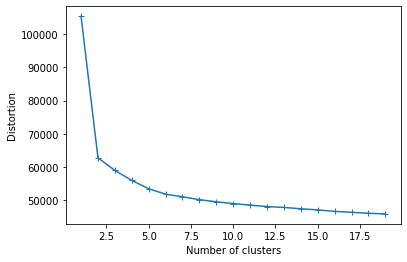

In [27]:
# エルボー方による推定。クラスター数を1から20に増やして、それぞれの距離の総和を求める
from sklearn.cluster import KMeans

dist_list =[]
for i in range(1,20):
    kmeans= KMeans(n_clusters=i, init='random', random_state=0)
    kmeans.fit(merge_all)
    dist_list.append(kmeans.inertia_)

    
# グラフを表示
plt.plot(range(1,20), dist_list,marker='+')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')

In [28]:
for i in [2, 5, 10, 20]:
  kmeans = KMeans(init='random', n_clusters=i, random_state=0)
  kmeans.fit(merge_all)
  merge_all['label_devided_by_{}_class'.format(i)] = kmeans.labels_

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


In [29]:
merge_all.head()

,0,1,2,3,4,5,6,7,8,9,...,763,764,765,766,767,description_len,label_devided_by_2_class,label_devided_by_5_class,label_devided_by_10_class,label_devided_by_20_class
0,-0.622226,-0.032659,0.085193,-0.354324,-0.456699,-0.251040,0.150931,-0.084210,-0.072143,-0.478698,...,-0.159992,-0.157810,-0.545107,-0.042181,0.443399,0.568094,0,0,7,12
1,-0.118194,0.067530,0.257243,0.044280,0.198945,-0.069988,-0.389483,-0.185668,0.171651,-0.367571,...,-0.201851,-0.189421,-0.233856,-0.062809,0.274777,2.356312,1,1,0,0
2,-0.201036,0.048412,0.285360,0.041703,0.038341,0.058666,-0.027448,-0.338271,-0.288287,-0.516094,...,-0.381009,-0.191602,-0.507205,-0.068363,0.002059,1.765046,1,3,5,14
3,-0.594164,-0.081837,-0.045628,-0.059279,-0.147906,-0.130730,0.528820,0.203797,-0.320909,-0.598327,...,-0.054430,-0.456759,-0.621450,-0.063379,0.314181,0.083956,0,4,8,4
4,-0.231389,-0.202489,0.131037,-0.321926,-0.135216,-0.230279,0.191065,0.167887,-0.157697,-0.513312,...,-0.038628,-0.275023,-0.429803,0.017688,0.480169,-0.649460,0,4,2,2


In [30]:
#aggrigation nice to haveだから一旦スルー
"""
def agg_func(input_df):
  agg_func = ["mean", "median", "max", "min", "std"]
  tmp = input_df.groupby(["Country", "month"])["pm25_mid"].agg(agg_func)
  output_df = pd.merge(data, tmp, how="left", on=["Country", "month"])[agg_func].add_suffix("_agg_func_pm25")
  return output_df
"""

'\ndef agg_func(input_df):\n  agg_func = ["mean", "median", "max", "min", "std"]\n  tmp = input_df.groupby(["Country", "month"])["pm25_mid"].agg(agg_func)\n  output_df = pd.merge(data, tmp, how="left", on=["Country", "month"])[agg_func].add_suffix("_agg_func_pm25")\n  return output_df\n'

In [31]:
kmeans_cols = ['label_devided_by_2_class',	'label_devided_by_5_class',	'label_devided_by_10_class', 'label_devided_by_20_class']
km_df = merge_all[kmeans_cols]
km_df.head()

,label_devided_by_2_class,label_devided_by_5_class,label_devided_by_10_class,label_devided_by_20_class
0,0,0,7,12
1,1,1,0,0
2,1,3,5,14
3,0,4,8,4
4,0,4,2,2


In [32]:
merge_train.head()

,id,description,jobflag,0,1,2,3,4,5,6,...,759,760,761,762,763,764,765,766,767,description_len
0,0,develop cut edg applic that perform superbl ac...,3,-0.622226,-0.032659,0.085193,-0.354324,-0.456699,-0.251040,0.150931,...,-0.336681,-0.025549,0.130011,0.168905,-0.159992,-0.157810,-0.545107,-0.042181,0.443399,867
1,1,design develop high qualiti scalabl effici sol...,3,-0.118194,0.067530,0.257243,0.044280,0.198945,-0.069988,-0.389483,...,-0.138183,-0.383871,0.066744,-0.217603,-0.201851,-0.189421,-0.233856,-0.062809,0.274777,1735
2,2,function point person network strategi work re...,4,-0.201036,0.048412,0.285360,0.041703,0.038341,0.058666,-0.027448,...,-0.399574,-0.103287,0.160107,-0.242952,-0.381009,-0.191602,-0.507205,-0.068363,0.002059,1448
3,3,work technic design develop releas deploy clou...,3,-0.594164,-0.081837,-0.045628,-0.059279,-0.147906,-0.130730,0.528820,...,-0.360094,0.079692,0.100495,0.407678,-0.054430,-0.456759,-0.621450,-0.063379,0.314181,632
4,4,quantifi resourc requir task project relat ent...,4,-0.231389,-0.202489,0.131037,-0.321926,-0.135216,-0.230279,0.191065,...,-0.051876,-0.071435,-0.065348,0.226792,-0.038628,-0.275023,-0.429803,0.017688,0.480169,276


In [33]:
merge_train = pd.merge(merge_train, km_df, left_index=True, right_index=True, how='inner')
merge_test = pd.merge(merge_test, km_df, left_index=True, right_index=True, how='inner')

In [34]:
merge_train.head()

,id,description,jobflag,0,1,2,3,4,5,6,...,763,764,765,766,767,description_len,label_devided_by_2_class,label_devided_by_5_class,label_devided_by_10_class,label_devided_by_20_class
0,0,develop cut edg applic that perform superbl ac...,3,-0.622226,-0.032659,0.085193,-0.354324,-0.456699,-0.251040,0.150931,...,-0.159992,-0.157810,-0.545107,-0.042181,0.443399,867,0,0,7,12
1,1,design develop high qualiti scalabl effici sol...,3,-0.118194,0.067530,0.257243,0.044280,0.198945,-0.069988,-0.389483,...,-0.201851,-0.189421,-0.233856,-0.062809,0.274777,1735,1,1,0,0
2,2,function point person network strategi work re...,4,-0.201036,0.048412,0.285360,0.041703,0.038341,0.058666,-0.027448,...,-0.381009,-0.191602,-0.507205,-0.068363,0.002059,1448,1,3,5,14
3,3,work technic design develop releas deploy clou...,3,-0.594164,-0.081837,-0.045628,-0.059279,-0.147906,-0.130730,0.528820,...,-0.054430,-0.456759,-0.621450,-0.063379,0.314181,632,0,4,8,4
4,4,quantifi resourc requir task project relat ent...,4,-0.231389,-0.202489,0.131037,-0.321926,-0.135216,-0.230279,0.191065,...,-0.038628,-0.275023,-0.429803,0.017688,0.480169,276,0,4,2,2


In [35]:
merge_train.to_csv('preprocessed_train.csv')
merge_test.to_csv('preprocessed_test.csv')